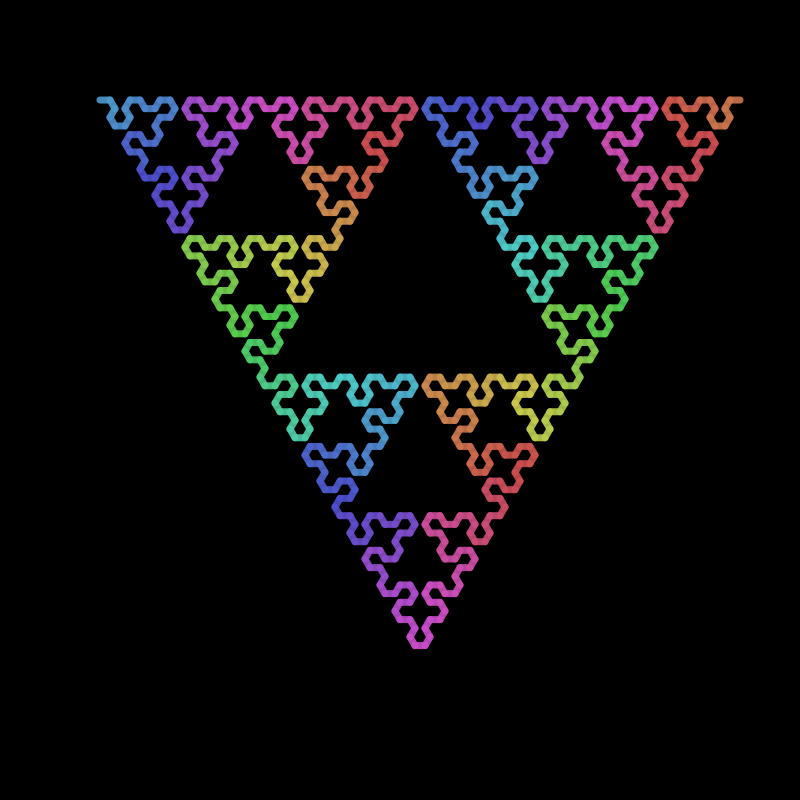

In [ ]:
using Lindenmayer
sierpinski_triangle = LSystem([
        "F" => "G+F+Gt",
        "G" => "7F-G-F"
    ],
    "G")

drawLSystem(sierpinski_triangle,
    forward=10,
    turn=60,
    iterations=6,
    startingx=-300,
    startingy=-300,
    filename=:svg)


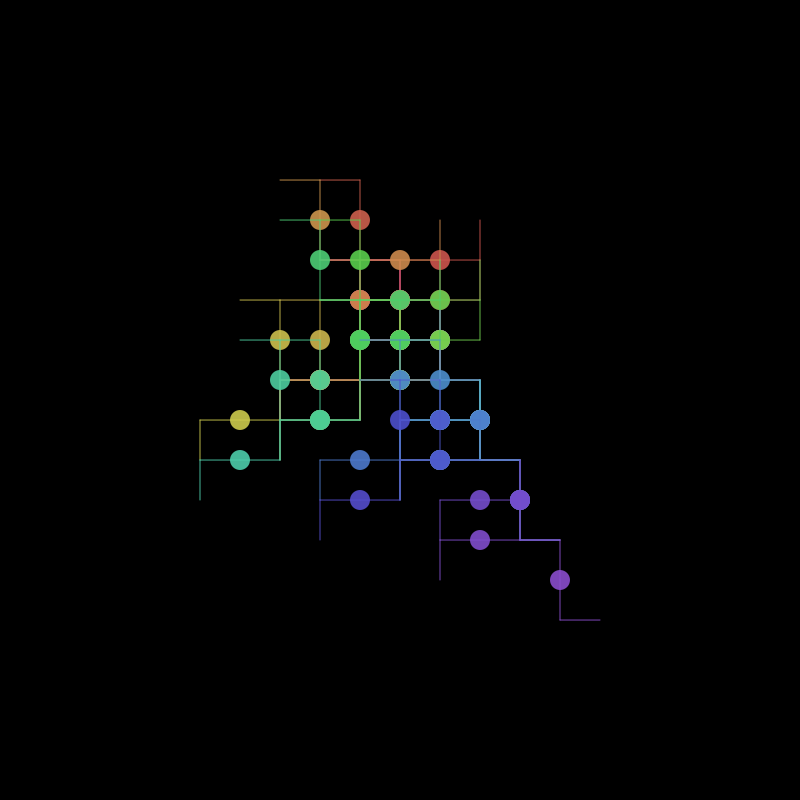

In [11]:
simple = LSystem(["F" => "F[t+FoF-F]"], "F")
drawLSystem(simple,
    forward=40,
    turn=90,
    iterations=4,
    startingx=0,
    startingy=-100)


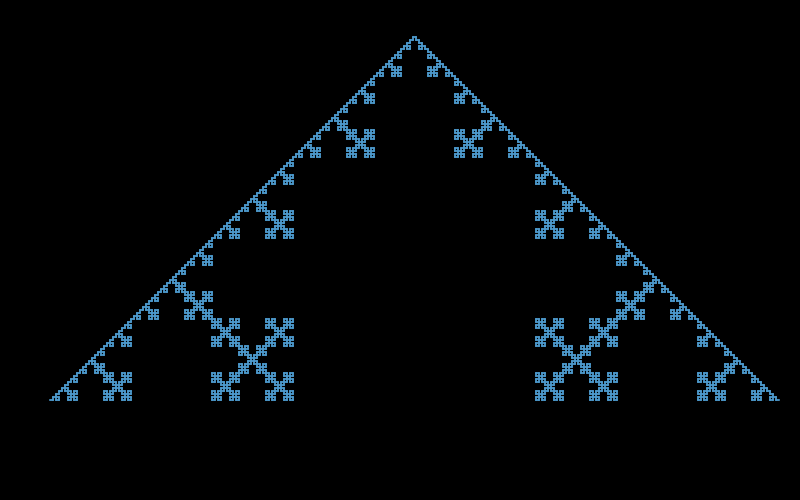

In [ ]:
koch_snowflake = LSystem(["F" => "F-F+F+F-F"], "2F")
drawLSystem(koch_snowflake,
    forward=3,
    iterations=5,
    startingx=-350,
    startingy=150,
    turn=90,
    height=500,
    filename=:svg)


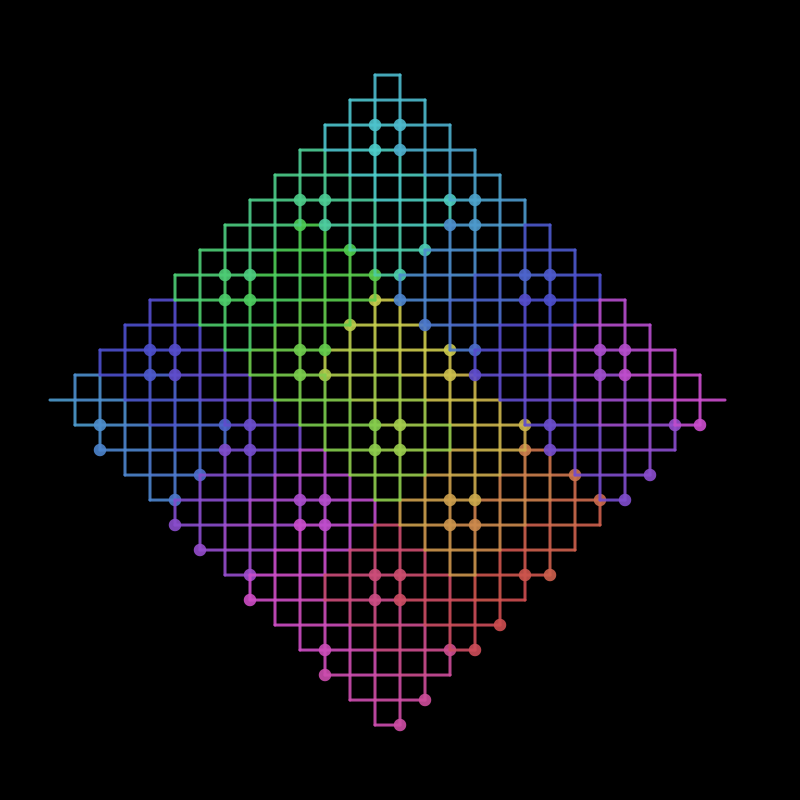

In [13]:
peano = LSystem(["F" => "TF+F-F-toF-F+F+F+F-F"], "3F")
drawLSystem(peano,
    forward=25,
    turn=90,
    iterations=3,
    startingx=-350,
    filename=:png)


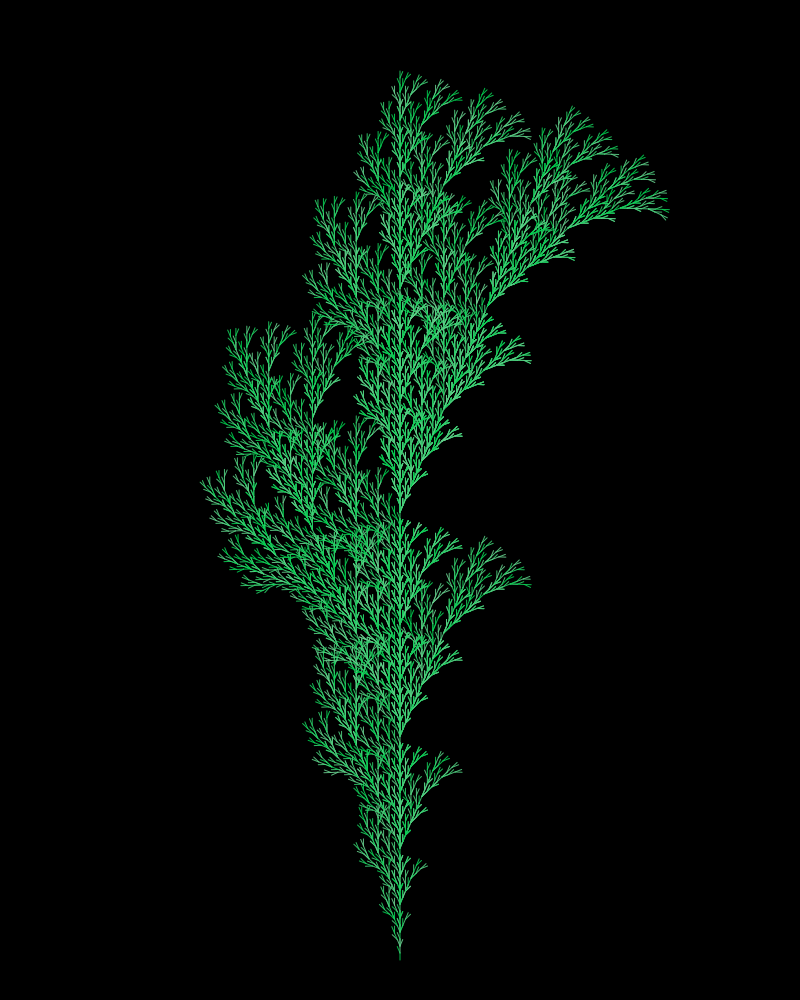

In [ ]:
plant = LSystem([
        "F" => "F[-F]cF[+F][F]"],
    "F") # use turn eg 17° or 23°

drawLSystem(plant,
    forward=7,
    startingpen=(0, 0.8, 0.3),
    startingx=0,
    startingy=460,
    startingorientation=-pi / 2,
    turn=23,
    iterations=6,
    height=1000,
    filename=:png)


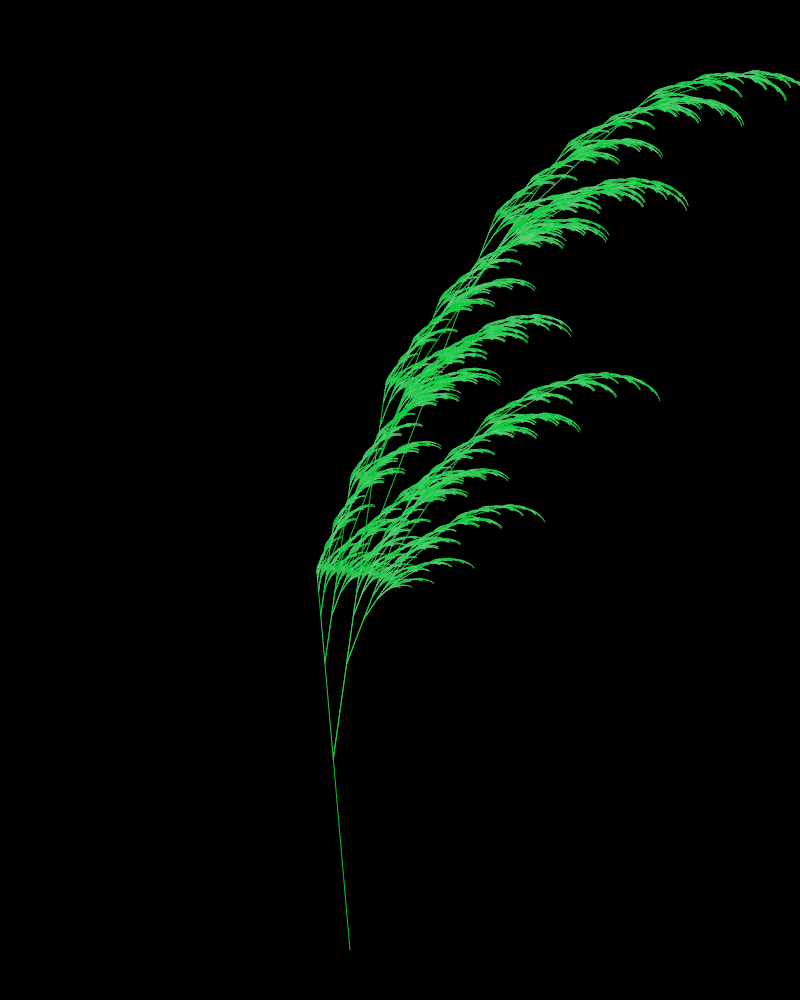

In [15]:
plant1 = LSystem([
        "F" => "FF",
        "X" => "F−[[cX]+X]+F[+FX]−X"
    ],
    "&1X")

drawLSystem(plant1,
    forward=3,
    turn=13,
    iterations=7,
    startingpen=(0, 0.8, 0.2),
    startingorientation=-pi / 2,
    startingx=-50,
    startingy=450,
    width=800,
    height=1000,
    filename=:png)


In [17]:
using Plots, GraphRecipes, Graphs

# --- データ構造の定義 ---

# 1つのブロックを表す構造体
struct Block
    level::Int
    # グローバルな座標 (可視化用)
    coordinates::Vector{Tuple{Float64,Float64}}
    # 内部の結合 (サイトインデックスのペア)
    bonds::Vector{Edge{Int}}
    # 外部接続用ポート (方向 => サイトインデックスのリスト)
    ports::Dict{Symbol,Vector{Int}}
    # このブロックに含まれるサイトの総数（オフセット計算用）
    num_sites::Int
end

# レベル0: 単一サイト (原子)
function atomic_block()
    return Block(
        0,
        [(0.0, 0.0)],           # 中心座標
        Edge{Int}[],            # 内部ボンドなし
        Dict(                   # どの方向からもこの1点が接続される
            :N => [1], :S => [1], :E => [1], :W => [1]
        ),
        1
    )
end

# ブロックを結合して新しいブロックを作る関数
# (左上, 右上, 左下, 右下) の順で配置
function compose_blocks(nw::Block, ne::Block, sw::Block, se::Block)
    new_level = nw.level + 1

    # サイトIDのオフセット計算
    offset_nw = 0
    offset_ne = nw.num_sites
    offset_sw = offset_ne + ne.num_sites
    offset_se = offset_sw + sw.num_sites
    total_sites = offset_se + se.num_sites

    # 1. 座標の統合とスケーリング (配置)
    # レベルが上がると座標を広げて配置する
    shift = 0.5 * (2.0^(nw.level))

    new_coords = vcat(
        [(x - shift, y + shift) for (x, y) in nw.coordinates], # NW
        [(x + shift, y + shift) for (x, y) in ne.coordinates], # NE
        [(x - shift, y - shift) for (x, y) in sw.coordinates], # SW
        [(x + shift, y - shift) for (x, y) in se.coordinates]  # SE
    )

    # 2. 内部ボンドの継承 (IDをシフトしてコピー)
    new_bonds = Vector{Edge{Int}}()

    # 子ブロック内部のボンドを追加
    function add_shifted_bonds(block, offset)
        for e in block.bonds
            push!(new_bonds, Edge(src(e) + offset, dst(e) + offset))
        end
    end
    add_shifted_bonds(nw, offset_nw)
    add_shifted_bonds(ne, offset_ne)
    add_shifted_bonds(sw, offset_sw)
    add_shifted_bonds(se, offset_se)

    # 3. ブロック間の「界面 (Interface)」を接続 (ここがボンド構造)
    # 例: NWのEastポートと、NEのWestポートをつなぐ

    # 水平結合 (NW-NE, SW-SE)
    connect_ports!(new_bonds, nw.ports[:E], ne.ports[:W], offset_nw, offset_ne)
    connect_ports!(new_bonds, sw.ports[:E], se.ports[:W], offset_sw, offset_se)

    # 垂直結合 (NW-SW, NE-SE)
    connect_ports!(new_bonds, nw.ports[:S], sw.ports[:N], offset_nw, offset_sw)
    connect_ports!(new_bonds, ne.ports[:S], se.ports[:N], offset_ne, offset_se)

    # 4. 新しい外部ポートの定義
    # 親ブロックのNorthポートは、NWのNorthとNEのNorthの結合
    new_ports = Dict(
        :N => vcat(nw.ports[:N] .+ offset_nw, ne.ports[:N] .+ offset_ne),
        :S => vcat(sw.ports[:S] .+ offset_sw, se.ports[:S] .+ offset_se),
        :E => vcat(ne.ports[:E] .+ offset_ne, se.ports[:E] .+ offset_se),
        :W => vcat(nw.ports[:W] .+ offset_nw, sw.ports[:W] .+ offset_sw)
    )

    return Block(new_level, new_coords, new_bonds, new_ports, total_sites)
end

# ポート同士を結合するヘルパー関数
function connect_ports!(bonds, portA, portB, offsetA, offsetB)
    # ポートのサイズが一致していることを想定 (正方格子なら一致する)
    for (pinA, pinB) in zip(portA, portB)
        push!(bonds, Edge(pinA + offsetA, pinB + offsetB))
    end
end

# --- 実行と可視化 ---

# 再帰的に生成
function generate_recursive_lattice(generations::Int)
    blk = atomic_block()
    for _ in 1:generations
        blk = compose_blocks(blk, blk, blk, blk)
    end
    return blk
end

# レベル3 (8x8) の格子を生成
lattice = generate_recursive_lattice(3)

# グラフ変換してプロット
g = SimpleGraph(lattice.num_sites)
for e in lattice.bonds
    add_edge!(g, src(e), dst(e))
end

# 座標の取り出し
xs = [p[1] for p in lattice.coordinates]
ys = [p[2] for p in lattice.coordinates]

# プロット
# graphplotを使うとトポロジーが見やすい
p = plot(aspect_ratio=1, axis=nothing, border=:none)
plot!(p, g, x=xs, y=ys,
    markersize=2,
    linecolor=:black,
    markercolor=:blue,
    curves=false, # 直線で描画
    title="Hierarchical Square Lattice (Level $(lattice.level))"
)


LoadError: ArgumentError: Package GraphRecipes not found in current path.
- Run `import Pkg; Pkg.add("GraphRecipes")` to install the GraphRecipes package.